In [1]:
import torch

from plot_domination import plot_pareto_domination, plot_scalarized_domination
from scalarize.utils.scalarization_functions import (
    AugmentedChebyshevScalarization,
    ChebyshevScalarization,
    HypervolumeScalarization,
    LpScalarization,
)

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amssymb}"

In [2]:
N = 500
X = torch.linspace(-0.05, 1.05, N)
Y = torch.linspace(-0.05, 1.05, N)
A, B = torch.meshgrid(X, Y, indexing="xy")

# (N*N x 2)-dim array
Z = torch.column_stack([A.reshape(N * N, 1), B.reshape(N * N, 1)])

utopia = torch.tensor([[0.6, 0.75]])
nadir = torch.tensor([[0, 0]])

utopia_set = torch.tensor(
    [
        [0.5, 0.8],
        [0.6, 0.75],
        [0.7, 0.7],
        [0.75, 0.6],
        [0.8, 0.5],
    ]
)

r = torch.tensor([[0.1, 0.3], [0.2, 0.20], [0.3, 0.16], [0.4, 0.05]])

latent_param = torch.linspace(0.001, 0.999, 2**10)
w = torch.column_stack([latent_param, 1 - latent_param])
h = torch.column_stack(
    [torch.cos(torch.pi * latent_param / 2), torch.sin(torch.pi * latent_param / 2)]
)
ones = torch.ones(1, 2)

In [3]:
s_fn_dict = {
    "Standard R2 utility": [
        ChebyshevScalarization(weights=w, ref_points=utopia),
        utopia,
        None,
        None,
    ],
    "Hypervolume indicator": [
        HypervolumeScalarization(weights=h, ref_points=nadir),
        None,
        nadir,
        None,
    ],
    r"$\text{IGD}$+ indicator": [
        LpScalarization(p=2, weights=ones, ref_points=utopia_set, clip=True),
        utopia_set,
        None,
        None,
    ],
    "D1 indicator": [
        ChebyshevScalarization(weights=ones / 2, ref_points=utopia_set),
        utopia_set,
        None,
        None,
    ],
}

C:\Users\Ben\Documents\GitHub\scalarize\notebooks\plot_domination\plot_domination.py:150: UserWarning: No contour levels were found within the data range.
  plt.contour(


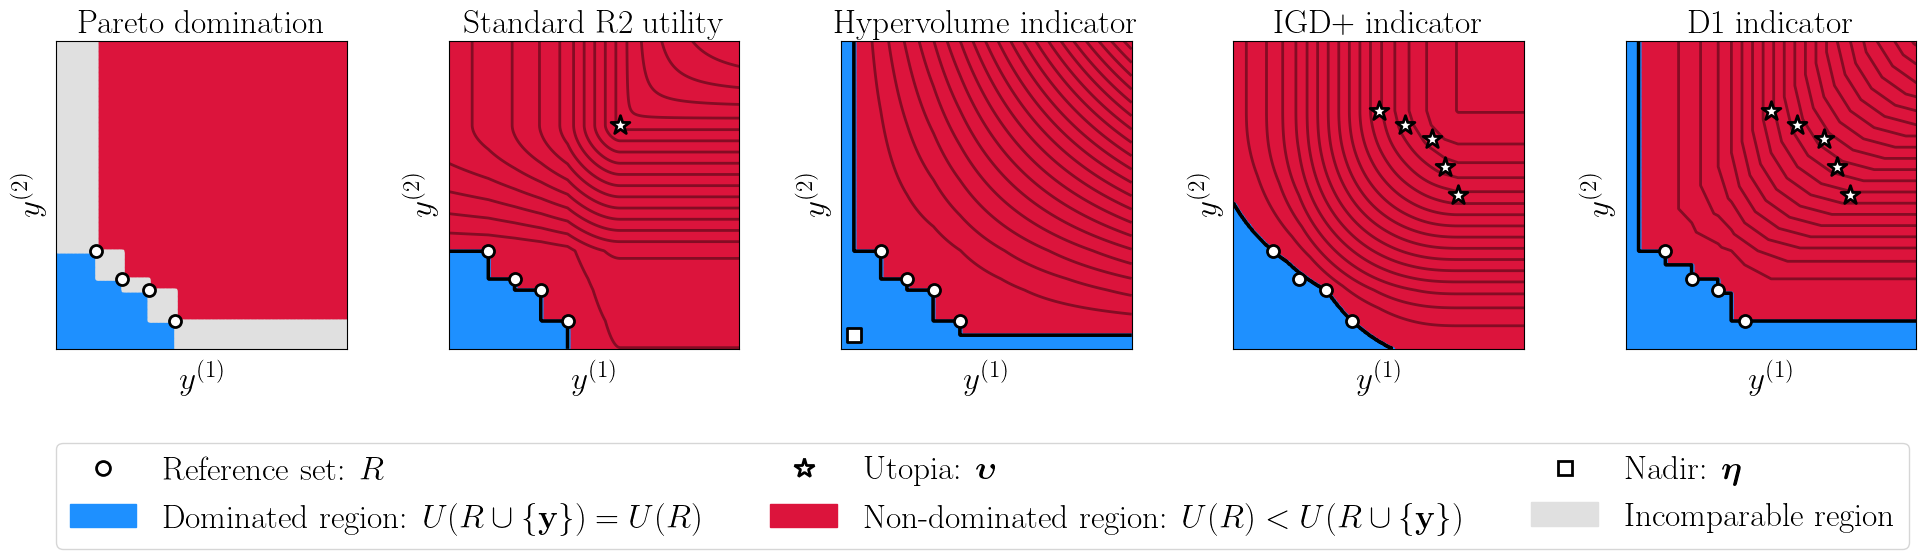

In [4]:
num_rows = 1
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 4))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.35
)

plt.subplot(num_rows, num_cols, 1)
plot_pareto_domination(Z, r, "Pareto domination", fontsize=24)

j = 1
for key, value in s_fn_dict.items():
    plt.subplot(num_rows, num_cols, j + 1)
    s_fn = value[0]
    Zr = s_fn(r)
    ZY = s_fn(Z)
    max_values = Zr.max(dim=0).values
    ZY = torch.maximum(ZY, max_values).mean(dim=-1)
    Zr = max_values.mean()

    plot_scalarized_domination(
        Z,
        ZY,
        Zr,
        r,
        utopia_set=value[1],
        nadir_set=value[2],
        title=key,
        contours=True,
        X=X,
        Y=Y,
        fontsize=24,
    )
    j = j + 1


red_patch = mpatches.Patch(
    color="crimson", label=r"Non-dominated region: $U(R) < U(R \cup \{\mathbf{y}\})$"
)
blue_patch = mpatches.Patch(
    color="dodgerblue", label=r"Dominated region: $U(R \cup \{\mathbf{y}\}) = U(R)$"
)
gray_patch = mpatches.Patch(color="#E0E0E0", label=r"Incomparable region", alpha=1)
black_dot = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference set: $R$",
)

white_star = mlines.Line2D(
    [],
    [],
    color="w",
    marker="*",
    linestyle="None",
    markersize=15,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Utopia: $\boldsymbol{\upsilon}$",
)
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Nadir: $\boldsymbol{\eta}$",
)

axes[0].legend(
    handles=[black_dot, blue_patch, white_star, red_patch, white_square, gray_patch],
    ncol=3,
    fontsize=24,
    loc=(0, -0.65),
)

plt.show()